In [1]:
# https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

In [2]:
import sys
import os
import math
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from sklearn.linear_model import LogisticRegression

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')
pd.options.display.max_columns = 999

In [3]:
check_cols = ['maturity_time', 'maturity_paid', 'maturity_time_stat_adj', 'maturity_paid_stat_adj',
              'target_loose', 'target_strict', 'loan_status', 'issue_d', 'end_d', 'id']
good_statuses = ['paid', 'current']

In [4]:
eval_loan_info = pd.read_feather(os.path.join(dpath,'eval_loan_info.fth'))
# scaled_pmt_hist = pd.read_feather(os.path.join(dpath,'scaled_pmt_hist.fth'))
base_loan_info = pd.read_feather(os.path.join(dpath,'base_loan_info.fth'))
# str_loan_info = pd.read_feather(os.path.join(dpath,'str_loan_info.fth'))

In [5]:
# get loans that are >= .95 maturity time, maturity paid, or status is in defaulted, charged_off, paid
trainable_loan_ids = eval_loan_info[(eval_loan_info['maturity_time_stat_adj'] >= .95) |
                               (eval_loan_info['maturity_paid_stat_adj'] >= .95) |
                               (eval_loan_info['loan_status'].isin(['paid', 'charged_off', 'defaulted']))
                              ]['id'].values

# fix step to data

In [ ]:
# quick fix to eval_loan_info, future times see if this cell needs to be run
eval_loan_info['maturity_time_stat_adj'] = np.where(
    (eval_loan_info['maturity_time_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'paid'), 1,
         np.where(
             (eval_loan_info['maturity_time_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'current'), 
 eval_loan_info['maturity_time'], eval_loan_info['maturity_time_stat_adj']))

eval_loan_info['maturity_paid_stat_adj'] = np.where(
    (eval_loan_info['maturity_paid_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'paid'), 1,
         np.where(
             (eval_loan_info['maturity_paid_stat_adj'] == -1) & (eval_loan_info['loan_status'] == 'current'), 
 eval_loan_info['maturity_paid'], eval_loan_info['maturity_paid_stat_adj']))

In [ ]:
eval_loan_info.to_feather(os.path.join(dpath,'eval_loan_info.fth'))

In [ ]:
(eval_loan_info['maturity_paid_stat_adj'] < 0).sum()

In [ ]:
(eval_loan_info['maturity_time_stat_adj'] < 0).sum()

# continue

In [6]:
trainable_loans = eval_loan_info[eval_loan_info['id'].isin(trainable_loan_ids)]
untrainable_loans = eval_loan_info[~eval_loan_info['id'].isin(trainable_loan_ids)]

In [7]:
# make sure untrainable loans actually look untrainable
untrainable_loans.groupby('loan_status',).apply(lambda x: x.sample(min(len(x), 3)))

end_d    issue_d  maturity_paid  maturity_time  \
loan_status                                                               
current     2258744 2019-06-01 2018-12-01       0.082585       0.100000   
            1538054 2019-06-01 2017-07-01       0.610934       0.638889   
            2247299 2019-06-01 2018-12-01       0.135442       0.166667   
grace_15    1594207 2019-06-01 2017-08-01       0.554908       0.611111   
            1465214 2019-06-01 2017-05-01       0.637747       0.694444   
            1865951 2019-06-01 2018-03-01       0.215719       0.250000   
late_30     2055592 2019-06-01 2018-08-01       0.132674       0.166667   
            1856727 2019-06-01 2018-03-01       0.270679       0.250000   
            2323445 2019-06-01 2019-02-01       0.054919       0.111111   

                     maturity_time_stat_adj  maturity_paid_stat_adj  \
loan_status                                                           
current     2258744                0.100000                0.082585   
            1538054                0.638889                0.610934   
            2247299                0.166667                0.135442   
grace_15    1594207                0.747222                0.710690   
            1465214                0.801389                0.764536   
            1865951                0.512500                0.490218   
late_30     2055592                0.700000                0.687763   
            1856727                0.730000                0.737444   
            2323445                0.680000                0.659771   

                     rem_to_be_paid  roi_simple  target_loose  target_strict  \
loan_status                                                                    
current     2258744    12672.349609    0.114075             0              0   
            1538054     3384.533447    0.708611             0              0   
            2247299    11353.901367    0.177870             0              0   
grace_15    1594207     2976.467041    0.742168             0              1   
            1465214     4389.191895    0.772718             0              1   
            1865951    17147.558594    0.314433             0              1   
late_30     2055592    29557.306641    0.226068             0              1   
            1856727     9834.277344    0.364987             0              1   
            2323445     2947.684570    0.068516             0              1   

                    loan_status         id grade  int_rate  term      0.05  \
loan_status                                                                  
current     2258744     current  145412458     C    0.1356    60 -0.886221   
            1538054     current  112734200     B    0.0993    36 -0.323714   
            2247299     current  145047700     D    0.1894    36 -0.823328   
grace_15    1594207    grace_15  116711866     D    0.2000    36 -0.254212   
            1465214    grace_15  107696247     C    0.1262    36 -0.263293   
            1865951    grace_15  130399287     C    0.1601    60 -0.669873   
late_30     2055592     late_30  137818658     E    0.2340    60 -0.776837   
            1856727     late_30  130065067     C    0.1407    60 -0.622480   
            2323445     late_30  147574928     C    0.1502    36 -0.931079   

                         0.06      0.07      0.08      0.09       0.1  \
loan_status                                                             
current     2258744 -0.886503 -0.886784 -0.887064 -0.887342 -0.887620   
            1538054 -0.330033 -0.336269 -0.342424 -0.348498 -0.354494   
            2247299 -0.823772 -0.824215 -0.824657 -0.825096 -0.825534   
grace_15    1594207 -0.260883 -0.267471 -0.273977 -0.280401 -0.286745   
            1465214 -0.270472 -0.277553 -0.284539 -0.291430 -0.298228   
            1865951 -0.671901 -0.673910 -0.675902 -0.677877 -0.679834   
late_30     2055592 -0.777664 -0.778486 -0.779304 -0.780118 -0.780927   
            1856727 

In [8]:
# make sure untrainable loans actually look untrainable
untrainable_loans.groupby('loan_status',).apply(lambda x: x.sample(min(len(x), 3)))

end_d    issue_d  maturity_paid  maturity_time  \
loan_status                                                               
current     1603288 2019-06-01 2017-10-01       0.685595       0.555556   
            1582048 2019-06-01 2017-08-01       0.583409       0.611111   
            2030694 2019-06-01 2018-07-01       0.277556       0.305556   
grace_15    1312635 2019-06-01 2017-01-01       0.750532       0.805556   
            1661287 2019-06-01 2017-10-01       0.538541       0.555556   
            442167  2019-06-01 2014-11-01       0.883286       0.916667   
late_30     2047301 2019-06-01 2018-07-01       0.135876       0.183333   
            2309086 2019-06-01 2019-02-01       0.054925       0.111111   
            1847563 2019-06-01 2018-03-01       0.216708       0.250000   

                     maturity_time_stat_adj  maturity_paid_stat_adj  \
loan_status                                                           
current     1603288                0.555556                0.685595   
            1582048                0.611111                0.583409   
            2030694                0.305556                0.277556   
grace_15    1312635                0.873611                0.837846   
            1661287                0.711111                0.700052   
            442167                 0.945833                0.924136   
late_30     2047301                0.706000                0.688915   
            2309086                0.680000                0.659773   
            1847563                0.730000                0.718015   

                     rem_to_be_paid  roi_simple  target_loose  target_strict  \
loan_status                                                                    
current     1603288    13757.421875    0.749990             0              0   
            1582048     9854.240234    0.718763             0              0   
            2030694    19806.601562    0.304380             0              0   
grace_15    1312635     1663.072876    0.981059             0              1   
            1661287    11943.015625    0.633545             0              1   
            442167      4409.315430    1.112314             0              1   
late_30     2047301    23525.267578    0.184956             0              1   
            2309086    16505.261719    0.068517             0              1   
            1847563    13593.006836    0.358160             0              1   

                    loan_status         id grade  int_rate  term      0.05  \
loan_status                                                                  
current     1603288     current  117188226     A    0.0721    36 -0.281808   
            1582048     current  115385648     C    0.1408    36 -0.311617   
            2030694     current  136833957     A    0.0611    36 -0.702148   
grace_15    1312635    grace_15   95142637     D    0.1799    36 -0.073217   
            1661287    grace_15  120560899     B    0.1091    36 -0.390531   
            442167     grace_15   34353102     B    0.0949    60  0.014291   
late_30     2047301     late_30  137517755     B    0.1273    60 -0.817090   
            2309086     late_30  147071169     C    0.1502    36 -0.931080   
            1847563     late_30  129695844     D    0.2185    60 -0.651031   

                         0.06      0.07      0.08      0.09       0.1  \
loan_status                                                             
current     1603288 -0.288136 -0.294389 -0.300569 -0.306676 -0.312712   
            1582048 -0.317766 -0.323839 -0.329836 -0.335758 -0.341606   
            2030694 -0.703495 -0.704833 -0.706161 -0.707482 -0.708793   
grace_15    1312635 -0.083750 -0.094117 -0.104320 -0.114363 -0.124249   
            1661287 -0.395475 -0.400363 -0.405195 -0.409973 -0.414697   
            442167  -0.007691 -0.029017 -0.049710 -0.069791 -0.089281   
late_30     2047301 -0.817771 -0.818448 -0.819122 -0.819792 -0.820458   
            2309086 

In [9]:
trainable_eli = trainable_loans
trainable_li = base_loan_info[base_loan_info['id'].isin(trainable_loan_ids)]
print(trainable_eli.shape, trainable_li.shape)

(1473189, 46) (1473189, 103)


In [10]:
df = trainable_li.merge(trainable_eli[['target_strict', 'id', 'loan_status']], on='id')

# split into time_series_cv splits

In [11]:
df.drop('loan_status', axis=1, inplace=True)

In [12]:
# get categorical feature indices for catboost
obj_cols = df.select_dtypes(['object', 'datetime']).columns
categorical_features_indices = [df.columns.get_loc(col) for col in obj_cols]
obj_cols

Index(['initial_list_status', 'application_type', 'is_inc_v',
       'sec_app_earliest_cr_line', 'emp_length', 'addr_zip',
       'earliest_cr_line', 'is_inc_v_joint', 'home_ownership', 'grade',
       'purpose', 'addr_state', 'sub_grade'],
      dtype='object')

In [13]:
# map dates and strings to numbers
date_cols = df.select_dtypes(['datetime', 'object']).columns
for col in date_cols:
    mapper = {np.NaN: 0}
    for i, val in enumerate(sorted(df[col].unique()), 1):
        mapper[val] = i
    df[col] = df[col].replace(mapper)
    if col == 'issue_d':
        issue_d_mapper = mapper

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [14]:
# for scikit, make sure everything is number and nulls are filled
non_num_cols = df.select_dtypes(['object', 'datetime']).columns
assert len(non_num_cols) == 0
df.fillna(-9999, inplace=True)

In [36]:
# # split out the test set, say the last 12 months
# test = df[df['issue_d'] >= (df['issue_d'].max() - 12)]
# train = df[df['issue_d'] < (df['issue_d'].max() - 12)]
test_ids = eval_loan_info[eval_loan_info['issue_d'] >= (eval_loan_info['issue_d'].max() + pd.DateOffset(months=-12))]['id'].values
test = df.query('id in @test_ids')
train = df.query('id not in @test_ids')

In [37]:
print(test.shape)
test.head()

(69868, 104)


,total_il_high_credit_limit,initial_list_status,inq_last_12m,tax_liens,fico_range_low,sec_app_num_rev_accts,avg_cur_bal,open_act_il,total_bal_ex_mort,application_type,pct_tl_nvr_dlq,sec_app_chargeoff_within_12_mths,sec_app_inq_last_6_mths,id,is_inc_v,num_actv_rev_tl,mort_acc,num_il_tl,percent_bc_gt_75,collections_12_mths_ex_med,revol_bal_joint,total_bal_il,open_il_12m,sec_app_mths_since_last_major_derog,installment,num_op_rev_tl,pub_rec,annual_inc,open_rv_12m,tot_coll_amt,sec_app_revol_util,sec_app_earliest_cr_line,emp_length,term,mths_since_last_major_derog,max_bal_bc,tot_cur_bal,delinq_amnt,sec_app_collections_12_mths_ex_med,chargeoff_within_12_mths,all_util,total_acc,revol_util,mths_since_recent_revol_delinq,dti,open_acc,inq_fi,mo_sin_rcnt_tl,int_rate,mths_since_last_record,total_bc_limit,num_actv_bc_tl,addr_zip,num_bc_sats,dti_joint,open_il_24m,earliest_cr_line,delinq_2_yrs,num_tl_op_past_12m,pub_rec_bankruptcies,num_tl_90g_dpd_24m,mths_since_last_delinq,inq_last_6_mths,tot_hi_cred_lim,num_sats,mo_sin_old_il_acct,num_bc_tl,fico_range_high,bc_open_to_buy,num_accts_ever_12_0_ppd,total_rev_hi_lim,open_rv_24m,annual_inc_joint,is_inc_v_joint,i_l_util,num_rev_tl_bal_gt_0,num_tl_12_0dpd_2m,mths_since_rcnt_il,sec_app_fico_range_low,sec_app_mort_acc,num_rev_accts,acc_open_past_24_mths,home_ownership,grade,mths_since_recent_bc_dlq,sec_app_fico_range_high,num_tl_30dpd,loan_amount,total_cu_tl,purpose,acc_now_delinq,mo_sin_old_rev_tl_op,open_acc_6m,funded_amount,addr_state,revol_bal,mo_sin_rcnt_rev_tl_op,sec_app_open_acc,mths_since_recent_bc,sec_app_open_act_il,bc_util,sub_grade,mths_since_recent_inq,target_strict
935737,66132.0,2,3.0,0.0,705.0,-9999.0,11717.0,2.0,68148.0,1,1.0,-9999.0,-9999.0,74617043,1,4.0,1.0,9.0,0.250,0.0,-9999.0,55010.0,3.0,-9999.0,197.999451,12.0,0.0,70000.0,2.0,0.0,-9999.0,1,4,36,-9999.0,7123.0,175755.0,0.0,-9999.0,0.0,0.54,22.0,0.326,-9999.0,0.2189,15.0,4.0,2.0,0.1155,-9999.0,31600.0,3.0,738,8.0,-9999.0,5.0,585,0.0,5.0,0.0,0.0,-9999.0,1.0,252460.0,15.0,67.0,8.0,709.0,18566.0,0.0,40300.0,6.0,-9999.0,1,0.97,4.0,0.0,3.0,-9999.0,-9999.0,12.0,11.0,4,2,-9999.0,-9999.0,0.0,6000.0,1.0,2,0.0,49.0,3.0,6000.0,44,13138.0,2.0,-9999.0,2.0,-9999.0,0.412,9,4.0,1
1226126,5322.0,2,4.0,0.0,705.0,-9999.0,5256.0,1.0,3685.0,1,1.0,-9999.0,-9999.0,100065804,1,7.0,2.0,10.0,0.000,0.0,-9999.0,739.0,1.0,-9999.0,193.377441,14.0,0.0,32000.0,3.0,1703.0,-9999.0,1,12,36,-9999.0,383.0,78837.0,0.0,-9999.0,0.0,0.15,29.0,0.156,-9999.0,0.1669,16.0,1.0,4.0,0.0992,-9999.0,9500.0,2.0,372,4.0,-9999.0,2.0,631,0.0,5.0,0.0,0.0,-9999.0,1.0,99822.0,16.0,123.0,7.0,709.0,9111.0,0.0,18900.0,5.0,-9999.0,1,0.14,7.0,0.0,12.0,-9999.0,-9999.0,17.0,8.0,1,2,-9999.0,-9999.0,0.0,6000.0,0.0,3,0.0,139.0,2.0,6000.0,43,2946.0,4.0,-9999.0,8.0,-9999.0,0.041,7,4.0,1
1351636,43055.0,2,1.0,2.0,710.0,-9999.0,16643.0,3.0,39318.0,1,1.0,-9999.0,-9999.0,121324916,3,9.0,2.0,6.0,0.111,0.0,-9999.0,12502.0,0.0,-9999.0,1220.624390,12.0,2.0,181000.0,2.0,0.0,-9999.0,1,2,36,-9999.0,6545.0,266281.0,0.0,-9999.0,0.0,0.34,21.0,0.368,-9999.0,0.1425,16.0,0.0,7.0,0.0796,12.0,67700.0,8.0,567,9.0,-9999.0,1.0,478,0.0,2.0,0.0,0.0,-9999.0,1.0,359463.0,16.0,89.0,9.0,714.0,42705.0,0.0,72900.0,4.0,-9999.0,1,0.29,9.0,0.0,24.0,-9999.0,-9999.0,13.0,5.0,1,1,-9999.0,-9999.0,0.0,38975.0,4.0,3,0.0,292.0,0.0,38975.0,27,26816.0,7.0,-9999.0,7.0,-9999.0,0.369,5,5.0,0
1362135,46096.0,1,1.0,0.0,695.0,-9999.0,6848.0,6.0,61634.0,1,1.0,-9999.0,-9999.0,123056681,1,3.0,1.0,20.0,0.333,0.0,-9999.0,38933.0,1.0,-9999.0,484.114136,3.0,0.0,45000.0,1.0,0.0,-9999.0,1,4,36,-9999.0,15113.0,61634.0,0.0,-9999.0,0.0,0.64,24.0,0.445,-9999.0,0.2363,9.0,1.0,4.0,0.0734,-9999.0,51000.0,3.0,670,3.0,-9999.0,3.0,656,0.0,2.0,0.0,0.0,-9999.0,0.0,97096.0,9.0,115.0,3.0,699.0,28299.0,0.0,51000.0,1.0,-9999.0,1,0.85,3.0,0.0,8.0,-9999.0,-9999.0,3.0,5.0,1,1,-9999.0,-9999.0,0.0,15600.0,0.0,3,0.0,106.0,1.0,15600.0,19,22701.0,4.0,-9999.0,4.0,-9999.0,0.445,4,8.0,0
1381982,0.0,2,0.0,0.0,730.0,-9999.0,1371.0,0.0,10964.0,1,1.0,-9999.0,-9999.0,126108153,1,6.0,

In [38]:
print(train.shape)
train.head()

(1403321, 104)


,total_il_high_credit_limit,initial_list_status,inq_last_12m,tax_liens,fico_range_low,sec_app_num_rev_accts,avg_cur_bal,open_act_il,total_bal_ex_mort,application_type,pct_tl_nvr_dlq,sec_app_chargeoff_within_12_mths,sec_app_inq_last_6_mths,id,is_inc_v,num_actv_rev_tl,mort_acc,num_il_tl,percent_bc_gt_75,collections_12_mths_ex_med,revol_bal_joint,total_bal_il,open_il_12m,sec_app_mths_since_last_major_derog,installment,num_op_rev_tl,pub_rec,annual_inc,open_rv_12m,tot_coll_amt,sec_app_revol_util,sec_app_earliest_cr_line,emp_length,term,mths_since_last_major_derog,max_bal_bc,tot_cur_bal,delinq_amnt,sec_app_collections_12_mths_ex_med,chargeoff_within_12_mths,all_util,total_acc,revol_util,mths_since_recent_revol_delinq,dti,open_acc,inq_fi,mo_sin_rcnt_tl,int_rate,mths_since_last_record,total_bc_limit,num_actv_bc_tl,addr_zip,num_bc_sats,dti_joint,open_il_24m,earliest_cr_line,delinq_2_yrs,num_tl_op_past_12m,pub_rec_bankruptcies,num_tl_90g_dpd_24m,mths_since_last_delinq,inq_last_6_mths,tot_hi_cred_lim,num_sats,mo_sin_old_il_acct,num_bc_tl,fico_range_high,bc_open_to_buy,num_accts_ever_12_0_ppd,total_rev_hi_lim,open_rv_24m,annual_inc_joint,is_inc_v_joint,i_l_util,num_rev_tl_bal_gt_0,num_tl_12_0dpd_2m,mths_since_rcnt_il,sec_app_fico_range_low,sec_app_mort_acc,num_rev_accts,acc_open_past_24_mths,home_ownership,grade,mths_since_recent_bc_dlq,sec_app_fico_range_high,num_tl_30dpd,loan_amount,total_cu_tl,purpose,acc_now_delinq,mo_sin_old_rev_tl_op,open_acc_6m,funded_amount,addr_state,revol_bal,mo_sin_rcnt_rev_tl_op,sec_app_open_acc,mths_since_recent_bc,sec_app_open_act_il,bc_util,sub_grade,mths_since_recent_inq,target_strict
0,-9999.0,1,-9999.0,0.0,735.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,54734,2,-9999.0,-9999.0,-9999.0,-9999.000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,829.046021,-9999.0,0.0,85000.0,-9999.0,-9999.0,-9999.0,1,11,36,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,-9999.00,42.0,0.521,-9999.0,0.1948,10.0,-9999.0,-9999.0,0.1189,-9999.0,-9999.0,-9999.0,891,-9999.0,-9999.0,-9999.0,481,0.0,-9999.0,0.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,739.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,4,2,-9999.0,-9999.0,-9999.0,25000.0,-9999.0,3,0.0,-9999.0,-9999.0,25000.0,5,28854.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000,9,-9999.0,0
1,-9999.0,1,-9999.0,0.0,640.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,55521,1,-9999.0,-9999.0,-9999.0,-9999.000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,35.196629,-9999.0,0.0,30000.0,-9999.0,-9999.0,-9999.0,1,11,36,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,-9999.00,15.0,0.904,-9999.0,0.2384,9.0,-9999.0,-9999.0,0.1608,-9999.0,-9999.0,-9999.0,573,-9999.0,-9999.0,-9999.0,571,0.0,-9999.0,0.0,-9999.0,-9999.0,1.0,-9999.0,-9999.0,-9999.0,-9999.0,644.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,4,6,-9999.0,-9999.0,-9999.0,1000.0,-9999.0,3,0.0,-9999.0,-9999.0,1000.0,15,10125.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000,27,-9999.0,0
2,5929.0,2,6.0,0.0,665.0,-9999.0,596.0,1.0,8351.0,1,0.69,-9999.0,-9999.0,55716,1,13.0,0.0,11.0,0.857,0.0,-9999.0,502.0,0.0,-9999.0,139.140762,13.0,1.0,30784.0,4.0,0.0,-9999.0,1,11,36,31.0,1158.0,8351.0,0.0,-9999.0,0.0,0.74,36.0,0.740,-9999.0,0.1696,14.0,2.0,7.0,0.2499,28.0,6350.0,7.0,934,14.0,-9999.0,0.0,591,0.0,4.0,1.0,0.0,-9999.0,4.0,16579.0,14.0,160.0,17.0,669.0,907.0,1.0,10650.0,13.0,-9999.0,1,0.08,13.0,-9999.0,50.0,-9999.0,-9999.0,25.0,13.0,4,5,-9999.0,-9999.0,0.0,3500.0,4.0,3,0.0,127.0,0.0,3500.0,48,7849.0,7.0,-9999.0,7.0,-9999.0,0.790,24,2.0,0
3,-9999.0,1,-9999.0,0.0,705.0,-9999.0,-9999.0,-9999.0,-9999.0,1,-9999.00,-9999.0,-9999.0,55742,1,-9999.0,-9999.0,-9999.0,-9999.000,0.0,-9999.0,-9999.0,-9999.0,-9999.0,228.211746,-9999.0,0.0,65000.0,-9999.0,-9999.0,-9999.0,1,11,36,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,-9999.00,7.0,0.767,-9999.0,0.1429,7.0,-9999.0,-9999.0,0.1071,-9999.0,-9999.0,-9999.0,104,-9999.0,-9999.0,-9999.0,561,0.0,-9999

In [39]:
# see if theres any difference in pct defaulted from train and test
print(test['target_strict'].sum()/len(test), train['target_strict'].sum()/len(train))

# a slightly higher percentage of defaulting loans. This makes sense due to defaulting loans finishing faster, thus being able to be included in trainable loans, compared to ongoing loans that won't default but still need to reach term

0.24991412377626382 0.2300314753360065


In [40]:
# basic split for now, probably some leakage (using some loans issued in same month for train and validation. Go with this for now, come back and make better custom splits later)
from sklearn.model_selection import TimeSeriesSplit

In [41]:
tscv = TimeSeriesSplit(n_splits=5)

In [42]:
for train_index, test_index in tscv.split(train):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [     0      1      2 ... 233888 233889 233890] TEST: [233891 233892 233893 ... 467774 467775 467776]
TRAIN: [     0      1      2 ... 467774 467775 467776] TEST: [467777 467778 467779 ... 701660 701661 701662]
TRAIN: [     0      1      2 ... 701660 701661 701662] TEST: [701663 701664 701665 ... 935546 935547 935548]
TRAIN: [     0      1      2 ... 935546 935547 935548] TEST: [ 935549  935550  935551 ... 1169432 1169433 1169434]
TRAIN: [      0       1       2 ... 1169432 1169433 1169434] TEST: [1169435 1169436 1169437 ... 1403318 1403319 1403320]


In [43]:
y = train['target_strict']
train.drop('target_strict', axis=1, inplace=True)
X = train

X_train = X.iloc[train_index,:]
y_train = y.iloc[train_index]

X_valid = X.iloc[test_index,:]
y_valid = y.iloc[test_index]

y_test = test['target_strict']
test.drop('target_strict', axis=1, inplace=True)
X_test = test

/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# train

In [44]:
y_test_non_def, y_test_def = y_test.value_counts()
y_test_non_def, y_test_def

(52407, 17461)

In [45]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=1,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=1,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

In [47]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


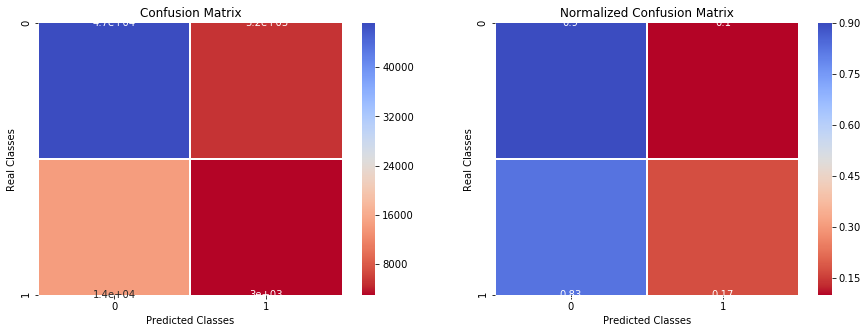

---Classification Report---
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     52407
           1       0.37      0.17      0.23     17461

    accuracy                           0.72     69868
   macro avg       0.57      0.54      0.53     69868
weighted avg       0.67      0.72      0.68     69868



In [48]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
PlotConfusionMatrix(y_test,pred,y_test_non_def,y_test_def)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


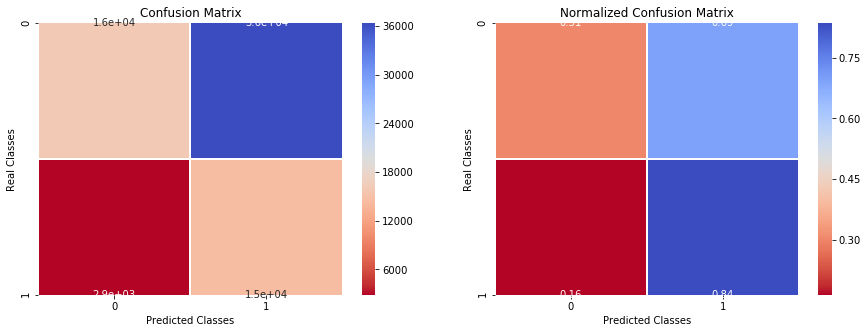

---Classification Report---
              precision    recall  f1-score   support

           0       0.85      0.31      0.45     52407
           1       0.29      0.84      0.43     17461

    accuracy                           0.44     69868
   macro avg       0.57      0.57      0.44     69868
weighted avg       0.71      0.44      0.44     69868



In [49]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train, y_train)
pred = lr_model.predict(X_test)
PlotConfusionMatrix(y_test,pred,y_test_non_def,y_test_def)

---Weight of 1 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


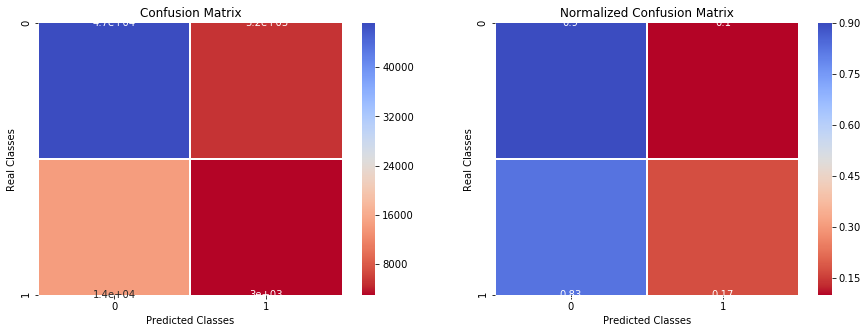

---Classification Report---
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     52407
           1       0.37      0.17      0.23     17461

    accuracy                           0.72     69868
   macro avg       0.57      0.54      0.53     69868
weighted avg       0.67      0.72      0.68     69868

---Weight of 5 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


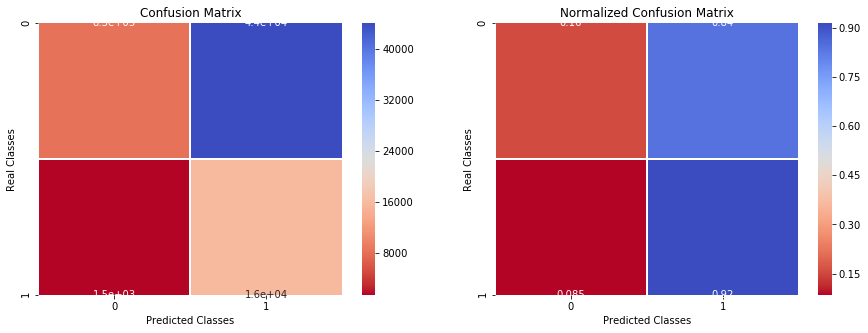

---Classification Report---
              precision    recall  f1-score   support

           0       0.85      0.16      0.27     52407
           1       0.27      0.92      0.41     17461

    accuracy                           0.35     69868
   macro avg       0.56      0.54      0.34     69868
weighted avg       0.70      0.35      0.30     69868

---Weight of 10 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


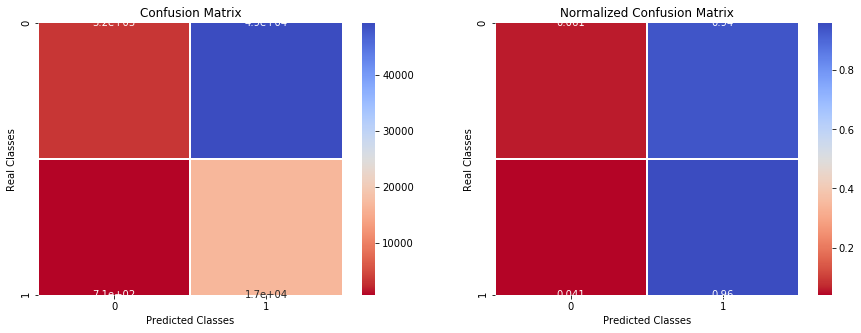

---Classification Report---
              precision    recall  f1-score   support

           0       0.82      0.06      0.11     52407
           1       0.25      0.96      0.40     17461

    accuracy                           0.29     69868
   macro avg       0.54      0.51      0.26     69868
weighted avg       0.68      0.29      0.19     69868

---Weight of 100 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


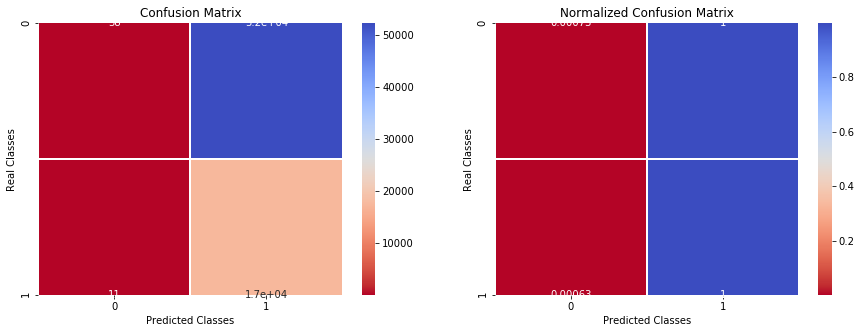

---Classification Report---
              precision    recall  f1-score   support

           0       0.78      0.00      0.00     52407
           1       0.25      1.00      0.40     17461

    accuracy                           0.25     69868
   macro avg       0.51      0.50      0.20     69868
weighted avg       0.64      0.25      0.10     69868

---Weight of 500 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


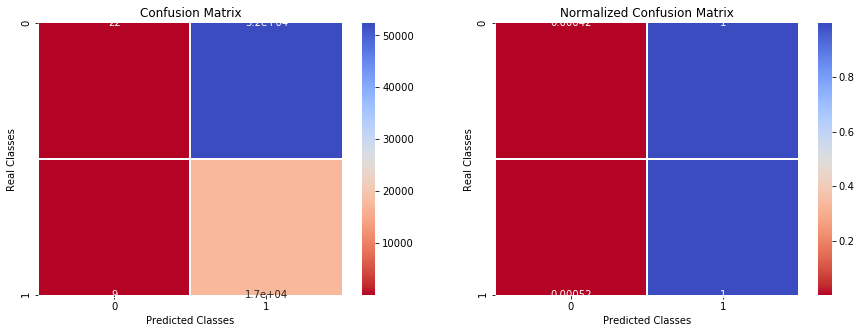

---Classification Report---
              precision    recall  f1-score   support

           0       0.71      0.00      0.00     52407
           1       0.25      1.00      0.40     17461

    accuracy                           0.25     69868
   macro avg       0.48      0.50      0.20     69868
weighted avg       0.59      0.25      0.10     69868

---Weight of 1000 for Default class---


/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


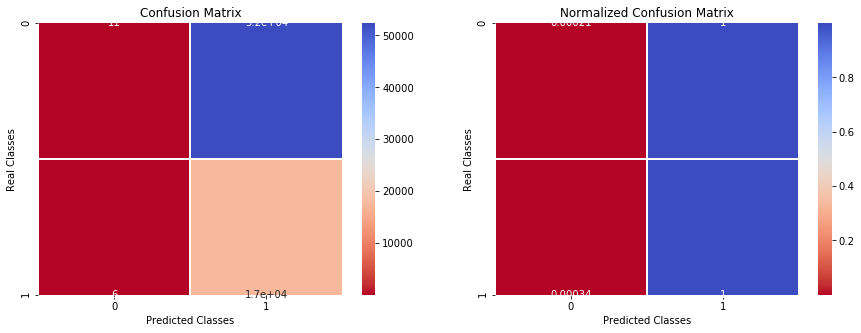

---Classification Report---
              precision    recall  f1-score   support

           0       0.65      0.00      0.00     52407
           1       0.25      1.00      0.40     17461

    accuracy                           0.25     69868
   macro avg       0.45      0.50      0.20     69868
weighted avg       0.55      0.25      0.10     69868



In [50]:
for w in [1,5,10,100,500,1000]:
    print('---Weight of {} for Default class---'.format(w))
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train, y_train)
    pred = lr_model.predict(X_test)
    PlotConfusionMatrix(y_test,pred,y_test_non_def,y_test_def)

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

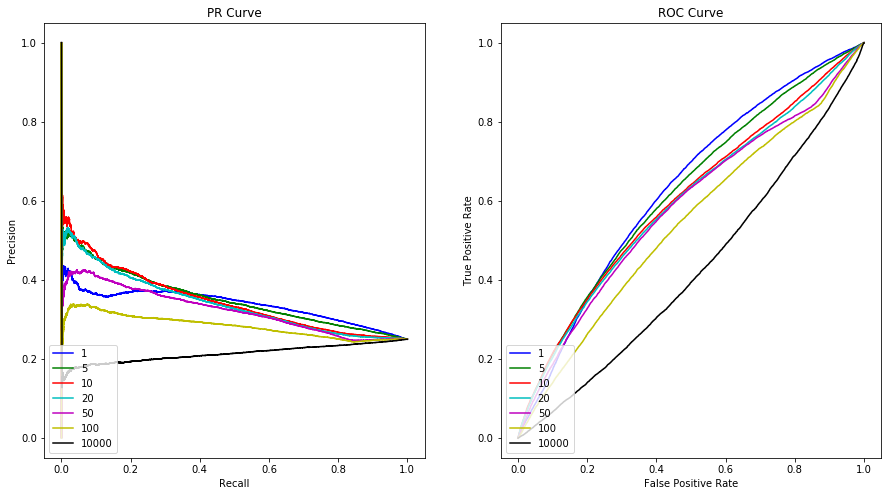

In [51]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

In [ ]:
# make a custom loss function that puts more emphasis on missclasifying defaulting
class CustomObjective(object):
    '''
    for derivations
    https://stats.stackexchange.com/questions/231220/how-to-compute-the-gradient-and-hessian-of-logarithmic-loss-question-is-based
    https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
    https://socratic.org/questions/what-is-the-derivative-of-e-x-8
    '''
    
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            e = np.exp(approxes[index])
            p = e / (1 + e)
            # der 1 and 2 have negative in front because they are gradient?
            der1 = 4*(-1)*(p - 1) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

In [ ]:
params = {
    'iterations': 1000,
#     'one_hot_max_size': 45,
#     'learning_rate': 0.01,
    'has_time': True,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
    'boosting_type': 'Ordered',
#     'loss_function': 'Log',
    'custom_metric': ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC'],
    'od_type': 'Iter',
    'od_wait': 300,
}

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_valid, y_valid),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

In [ ]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(**params)
    
    print(model.get_params())
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params(),
        type = 'TimeSeries',
        plot=True,
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [ ]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
#     'iterations': 1000,
#     'one_hot_max_size': 45,
#     'learning_rate': 0.01,
    'has_time': True,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
    'boosting_type': 'Ordered',
    'loss_function': 'Logloss',
#     'custom_metric': ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC'],
#     'od_type': 'Iter',
#     'od_wait': 300,
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

In [ ]:
cv??